# Demonstration of soScope working on Poisson distribution

This is a demonstration of soScope analysis on simulated data with Poisson distribution.

Bohan Li @ Deng ai Lab @ BUAA 2023.

Software provided as is under MIT License.

In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_all(6172)

## Scene Preset

Experiment: Mouse embryo tissue resolution enhancement experiment.

Inputs: 1,974 “low-resolution” spots with aggregated peak counts (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), and spatial neighboring relations (A)

Outputs: Profiles of 7,896 “enhanced-resolution” spots corresponding to the 1,776 sequencing spots generated using Visium platform.

Genes analyzed: Top 15 marker peaks in four selected region.



In [2]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# svae_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# svae_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
saved_model = two_step_train(logging=not None,
                             vgae_experiment_dir='experiments/VGAE_Pois',
                             svae_experiment_dir='experiments/soScope_Pois',
                             data_dir='DataSet/Poisson_demo/',
                             vgae_config_file='config/Poisson/VGAE.yml',
                             svae_config_file='config/Poisson/soScope.yml',
                             device='cuda',
                             checkpoint_every=1000,
                             backup_every=200,
                             epochs=[5000, 5000],
                             num_neighbors=4
                            )

Step 1
<class 'soScope_model.training.vgae.VGAETrainer_Poisson'>
===There are 1974 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 4 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 71.49it/s]


Step 2
<class 'soScope_model.training.svae_Global_Poisson.soScope_Poisson'>
========== Optimization of soScope ============


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:27<00:00,  2.93it/s]


In [10]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.
infer(
        experiment_dir= 'experiments/soScope_Pois',
        non_negative=True,
        num_neighbors=4,
        data_dir= 'DataSet/Poisson_demo/',
        result_dir='DataSet/Poisson_demo/',
        device='cuda',
        saved_model=saved_model
)

<class 'soScope_model.training.svae_Global_Poisson.soScope_Poisson'>
Pretrained Model Loaded!
use passed trainer!
We built edges between every neighboring 4 nodes
Spatial Data Loaded


In [11]:
# Visualization
# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.

lr_count = np.load(f'DataSet/Poisson_demo/label.npy')
position = pd.read_csv(f'DataSet/Poisson_demo/colData.csv')
y = (-position['row']).tolist()
x = (-position['col']).tolist()

hr_count = np.load(f'DataSet/Poisson_demo/infer_subspot.npy')
en_position = pd.read_csv(f'DataSet/Poisson_demo/enhanced_position_with_center.csv')
en_y = (-en_position['row']).tolist()
en_x = (-en_position['col']).tolist()

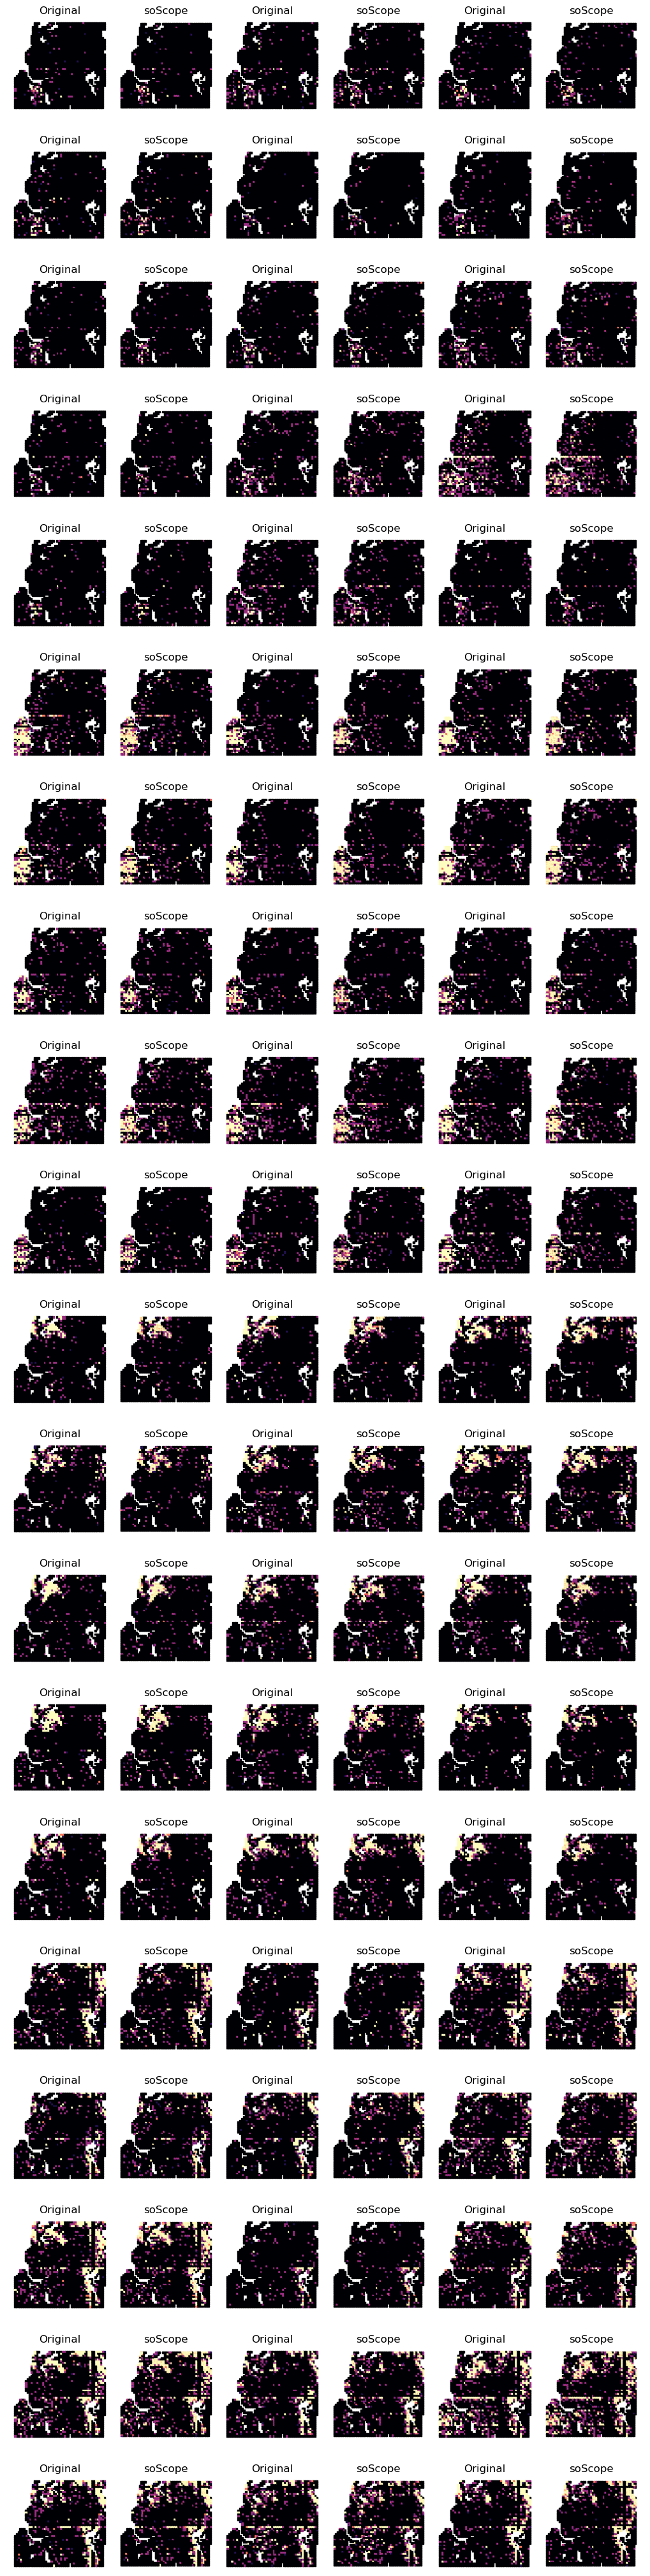

In [9]:
# Simulated resolution enhancement visualization. 
# Visualized data: top 60 variable peaks, contains Heart, Liver, Forebrain, and Spinal cord region (15 peaks for each region)
# arrangment in subplot: peak data (left) at original resolution, and scScope (right) predicted data at enhanced resolution

# Heart
cmap = 'magma'
fig = plt.figure(figsize=(10, 40), dpi=100)

for idx in range(60):
    gene_name = idx
    original_peak_count = lr_count[:, idx]
    
    # merged data visualization
    ax = fig.add_subplot(20, 6, 2*idx+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=4,
                marker = 's',
                c=original_peak_count,
                cmap=cmap,vmin=0.5,vmax=np.max(original_peak_count),
                )
    plt.title('Original', y=1)
    
    # soScope predicted data visualization
    ax = fig.add_subplot(20, 6, 2*idx+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=1,
                marker='s',
                c=hr_count[:, idx],
                cmap=cmap, vmin=0.5,vmax=np.max(original_peak_count),
                )
    plt.title('soScope', y=1)
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()